<h3>輸入原影像，經過壓縮轉換，再由轉換壓縮碼，還原成類原圖</h3>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
from glob import glob
import numpy
import pandas

In [3]:
import cv2

In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import keras
from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib import cm

<h3>環境設置</h3>

In [7]:
image_path = '/mnt/Treasury/Projects/ComputerVision/ObjectDetection/workspace/fish/source_images'
train_data_file = '/mnt/Treasury/Projects/ComputerVision/ObjectDetection/workspace/fish/data/train_labels.csv'
test_data_file = '/mnt/Treasury/Projects/ComputerVision/ObjectDetection/workspace/fish/data/test_labels.csv'

In [8]:
def show_image(my_image):
    global max_dim
    
    _my_image = numpy.reshape(my_image, max_dim)
    
    fig, ax = plt.subplots(dpi=120)
    
    ax.imshow(my_image)
    ax.axis('off')
    
    plt.show()

In [9]:
train_data = pandas.read_csv(train_data_file)

train_data.sort_values(['filename', 'class', 'xmin', 'ymin'], inplace=True)

In [10]:
train_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
3517,F000056.jpg,1920,1080,A,11,333,759,760
5540,F000057.jpg,1920,1080,A,12,337,769,767
3994,F000058.jpg,1920,1080,A,26,348,776,767
4480,F000061.jpg,1920,1080,A,1591,256,1920,616
5184,F000064.jpg,1920,1080,A,94,390,825,786


In [11]:
test_data = pandas.read_csv(test_data_file)
test_data.sort_values(['filename', 'class', 'xmin', 'ymin'], inplace=True)

In [12]:
test_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
347,F000064.jpg,1920,1080,A,94,390,825,786
346,F000064.jpg,1920,1080,B,1569,244,1920,615
1168,F000066.jpg,1920,1080,A,120,394,848,788
1169,F000066.jpg,1920,1080,B,1579,241,1920,606
816,F000086.jpg,1920,1080,B,1593,174,1920,487


In [13]:
train_image_files = list(set(train_data['filename']))
train_image_files[:5]

['F011984.jpg', 'F010698.jpg', 'F005846.jpg', 'F018586.jpg', 'F005858.jpg']

In [14]:
test_image_files = list(set(test_data['filename']))
test_image_files[:5]

['F003260.jpg', 'F009204.jpg', 'F004980.jpg', 'F014734.jpg', 'F017656.jpg']

<h3>載入魚影像檔</h3>

In [15]:
kernel = numpy.array([[-1, -1, -1], [-1, 11, -1], [-1, -1, -1]])

alpha = 0.6 # Contrast control (1.0-3.0)
beta = 2 # Brightness control (0-100)

In [16]:
def read_image_file(my_image_info, noise=False):
    global image_path
    
    my_image_file = '%s/%s' % (image_path, my_image_info.iloc[0]['filename'])

    _fish_image = cv2.imread(my_image_file, cv2.COLOR_BGR2RGB)
    _fish_image = cv2.filter2D(_fish_image, -1, kernel)
    _fish_image = cv2.convertScaleAbs(_fish_image.copy(), alpha=alpha, beta=beta)
    
    if noise:
        return _fish_image

    my_image = numpy.ones((1080, 1920, 3), numpy.uint8)

    for i in range(my_image_info.shape[0]):
        xmin = my_image_info.iloc[i]['xmin']
        xmax = my_image_info.iloc[i]['xmax']

        ymin = my_image_info.iloc[i]['ymin']
        ymax = my_image_info.iloc[i]['ymax']

        my_image[ymin:ymax, xmin:xmax, :] = _fish_image[ymin:ymax, xmin:xmax, :]
     
    return my_image

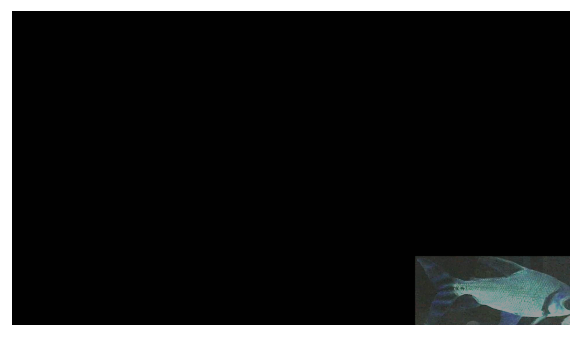

In [17]:
my_image_name = 'F010552.jpg'
my_image_info = train_data.loc[(train_data['filename']==my_image_name)]

my_image = read_image_file(my_image_info)

fig, ax = plt.subplots(dpi=120)
    
ax.imshow(my_image)
ax.axis('off')
    
plt.show()

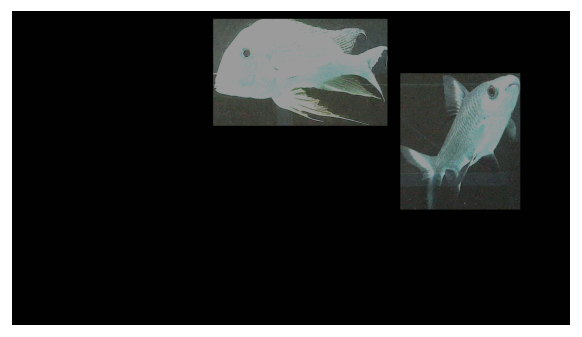

In [18]:
my_image_name = 'F015428.jpg'
my_image_info = test_data.loc[(test_data['filename']==my_image_name)]

my_image = read_image_file(my_image_info)

fig, ax = plt.subplots(dpi=120)
    
ax.imshow(my_image)
ax.axis('off')
    
plt.show()

In [19]:
max_dim = (256, 256, 3)

In [20]:
def load_data(my_image_files, my_data, noise=False):
    global train_data, test_data, max_dim

    my_images = []
    
    for my_image_name in my_image_files:
        my_image_info = my_data.loc[(my_data['filename']==my_image_name)]
        my_image = read_image_file(my_image_info, noise)
        my_image = cv2.resize(my_image.copy(), max_dim[:2], interpolation = cv2.INTER_AREA)

        my_images.append(numpy.reshape(my_image, max_dim))

    my_images = numpy.array(my_images)
    numpy.random.shuffle(my_images)

    return my_images

In [21]:
def load_dataset(noise=False):
    global train_image_files, train_data, test_image_files, test_data

    my_train_images = load_data(train_image_files, train_data, noise)
    my_test_images = load_data(test_image_files, test_data, noise)
      
    return my_train_images, my_test_images

In [22]:
x_train, x_test = load_dataset()

In [23]:
x_train_noise, x_test_noise = load_dataset(noise=True)

In [24]:
x_train.shape, x_test.shape

((3472, 256, 256, 3), (957, 256, 256, 3))

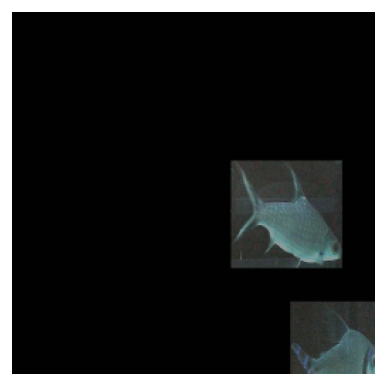

In [25]:
show_image(x_train[numpy.random.randint(len(x_train))])

<h3>將 0 ~ 255 值域，轉換為: 0 ~ 1</h3>

In [26]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [27]:
x_train_noise = x_train_noise.astype('float32') / 255.
x_test_noise = x_test_noise.astype('float32') / 255.

<h3>參數設置</h3>
<p>$$壓縮率: \frac {{256}*{256}={65536}}{64} = 1024$$</p>

In [28]:
encoding_dim = (32, 32, 64)

<h3>建立模型</h3>

In [43]:
input_img = keras.Input(shape=max_dim, name='input')

In [44]:
x = layers.Conv2D(384, (3, 3), activation='relu', padding='same', name='Conv2D_256')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_256')(x)
x = layers.Dropout(.2)(x)

In [45]:
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv2D_128')(x)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_128')(x)
x = layers.Dropout(.2)(x)

In [46]:
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_64')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name='encoded')(x)

In [47]:
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', name='Conv2DT_64')(encoded)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_64')(x)
x = layers.Dropout(.2)(x)

In [48]:
x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', name='Conv2DT_128')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_128')(x)
x = layers.Dropout(.2)(x)

In [49]:
x = layers.Conv2DTranspose(384, (3, 3), activation='relu', padding='same', name='Conv2DT_256')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_256')(x)

In [50]:
decoded = layers.Conv2D(max_dim[-1], (3, 3), padding='same', name='output')(x)

In [51]:
autoencoder = keras.Model(input_img, decoded)

In [52]:
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_256 (Conv2D)          (None, 256, 256, 384)     10752     
_________________________________________________________________
MaxPooling2D_256 (MaxPooling (None, 128, 128, 384)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 384)     0         
_________________________________________________________________
Conv2D_128 (Conv2D)          (None, 128, 128, 256)     884992    
_________________________________________________________________
MaxPooling2D_128 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 256)      

In [53]:
autoencoder.compile(optimizer='adam', loss='mse')  # binary_crossentropy

<h3>訓練模型</h3>

In [54]:
checkpointer = ModelCheckpoint(
    filepath='Noise-Color.hdf5', 
    monitor="val_loss", verbose=1, 
    save_best_only=True, mode='auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=48)

In [55]:
num_of_epoch = 1024
num_of_batch_size = 16

In [56]:
score = autoencoder.fit(x_train_noise, x_train,
                        epochs=num_of_epoch,
                        batch_size=num_of_batch_size,
                        shuffle=True,
                        validation_data=(x_test_noise, x_test),
                        callbacks=[checkpointer, earlyStop]
                       )

Epoch 1/1024
217/217 [==============================] - ETA: 0s - loss: 0.0184
Epoch 00001: val_loss improved from inf to 0.01837, saving model to Noise-Color.hdf5
217/217 [==============================] - 66s 306ms/step - loss: 0.0184 - val_loss: 0.0184
Epoch 2/1024
217/217 [==============================] - ETA: 0s - loss: 0.0165
Epoch 00002: val_loss improved from 0.01837 to 0.01827, saving model to Noise-Color.hdf5
217/217 [==============================] - 66s 306ms/step - loss: 0.0165 - val_loss: 0.0183
Epoch 3/1024
217/217 [==============================] - ETA: 0s - loss: 0.0165
Epoch 00003: val_loss improved from 0.01827 to 0.01822, saving model to Noise-Color.hdf5
217/217 [==============================] - 70s 322ms/step - loss: 0.0165 - val_loss: 0.0182
Epoch 4/1024
217/217 [==============================] - ETA: 0s - loss: 0.0165
Epoch 00004: val_loss did not improve from 0.01822
217/217 [==============================] - 71s 327ms/step - loss: 0.0165 - val_loss: 0.0182
Ep

217/217 [==============================] - ETA: 0s - loss: 0.0163
Epoch 00035: val_loss did not improve from 0.01811
217/217 [==============================] - 64s 297ms/step - loss: 0.0163 - val_loss: 0.0181
Epoch 36/1024
217/217 [==============================] - ETA: 0s - loss: 0.0163
Epoch 00036: val_loss did not improve from 0.01811
217/217 [==============================] - 64s 297ms/step - loss: 0.0163 - val_loss: 0.0182
Epoch 37/1024
217/217 [==============================] - ETA: 0s - loss: 0.0163
Epoch 00037: val_loss did not improve from 0.01811
217/217 [==============================] - 64s 297ms/step - loss: 0.0163 - val_loss: 0.0181
Epoch 38/1024
217/217 [==============================] - ETA: 0s - loss: 0.0163
Epoch 00038: val_loss did not improve from 0.01811
217/217 [==============================] - 64s 297ms/step - loss: 0.0163 - val_loss: 0.0181
Epoch 39/1024
217/217 [==============================] - ETA: 0s - loss: 0.0163
Epoch 00039: val_loss did not improve from

Epoch 72/1024
217/217 [==============================] - ETA: 0s - loss: 0.0161
Epoch 00072: val_loss did not improve from 0.01811
217/217 [==============================] - 65s 298ms/step - loss: 0.0161 - val_loss: 0.0183
Epoch 73/1024
217/217 [==============================] - ETA: 0s - loss: 0.0160
Epoch 00073: val_loss did not improve from 0.01811
217/217 [==============================] - 66s 303ms/step - loss: 0.0160 - val_loss: 0.0183
Epoch 74/1024
217/217 [==============================] - ETA: 0s - loss: 0.0160
Epoch 00074: val_loss did not improve from 0.01811
217/217 [==============================] - 67s 311ms/step - loss: 0.0160 - val_loss: 0.0183
Epoch 75/1024
217/217 [==============================] - ETA: 0s - loss: 0.0160
Epoch 00075: val_loss did not improve from 0.01811
217/217 [==============================] - 69s 317ms/step - loss: 0.0160 - val_loss: 0.0183
Epoch 76/1024
217/217 [==============================] - ETA: 0s - loss: 0.0160
Epoch 00076: val_loss did no

<h3>模型訓練績效</h3>

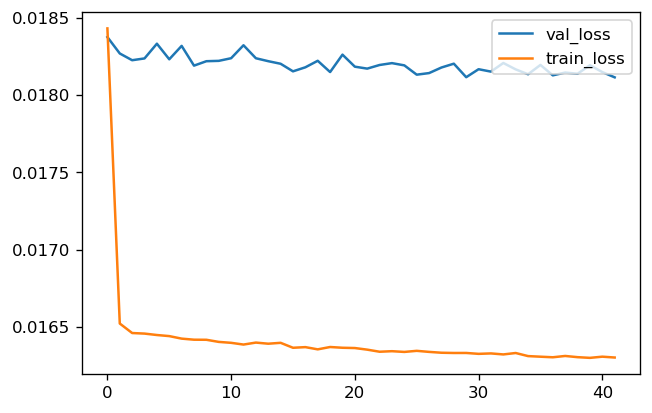

In [57]:
best_iteration = numpy.argmin(score.history['val_loss']) + 1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

fig, ax = plt.subplots(dpi=120)

ax.plot(val_scores, label='val_loss')
ax.plot(train_scores, label='train_loss')

plt.legend(loc='upper right')
plt.show()

<h3>隨機顯示抽象圖與假圖</h3>

In [58]:
faint_image_files = glob('%s/F*.jpg' % '/mnt/Treasury/Projects/ComputerVision/Fish-ID/FISH-1/7227/V0')

In [59]:
my_faint_images = []

for image_file in faint_image_files[:24]:
    _image_file = image_file.replace('\\', '/')

    
    _fish_image = cv2.imread(_image_file, cv2.COLOR_BGR2RGB)
    _fish_image = cv2.resize(_fish_image.copy(), max_dim[:2], interpolation = cv2.INTER_AREA)

    my_faint_images.append(numpy.reshape(_fish_image, max_dim))

my_faint_images = numpy.array(my_faint_images)

In [60]:
my_faint_images = my_faint_images.astype('float32') / 255.
my_faint_images = numpy.reshape(my_faint_images, (my_faint_images.shape[0],) + max_dim)

In [61]:
my_faint_images.shape

(24, 256, 256, 3)

<h3>產生假圖</h3>

In [62]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoded").output)

encoded_imgs = encoder.predict(my_faint_images)
encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), max_dim[0], max_dim[1], 1))

ValueError: cannot reshape array of size 3145728 into shape (24,256,256,1)

In [ ]:
decoded_imgs = autoencoder.predict(my_faint_images)

<h3>顯示原圖與假圖</h3>

In [ ]:
def find_faint_file_pos(my_image_id=None):
    global my_faint_images
    
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
    else:
        for j in range(len(faint_image_files)):
            image_file = read_image_single_file[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
        
    return pos

In [ ]:
i = find_faint_file_pos()

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(dpi=240, ncols=3)

ax0.imshow(my_faint_images[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.imshow(decoded_imgs[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(encoded_imgs[i].reshape(max_dim[0], max_dim[1]), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()